In [1]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
import csv
from pandas.tseries.offsets import MonthEnd
from datetime import datetime, timedelta, date
import requests
import json 
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from sklearn.utils.multiclass import unique_labels

from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.utils import resample


import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Convolution1D, MaxPooling1D
from keras.utils import np_utils
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

Using TensorFlow backend.


In [2]:
#### read in the flattened dataframes with the labels for the 98 to 2015 data
MSFT_df_98_to_15_df = pd.read_csv(r"/Users/fahad/project_repo/data/external/MSFT_flat_98_to_2015.csv")
AAPL_df_98_to_15_df = pd.read_csv(r"/Users/fahad/project_repo/data/external/AAPL_flat_98_to_2015.csv")
AMZN_df_98_to_15_df = pd.read_csv(r"/Users/fahad/project_repo/data/external/AMZN_flat_98_to_2015.csv")

In [3]:
###read in the flattened dataframes with the labels for 2015 to 2019
MSFT_df_15_to_19_df = pd.read_csv(r"/Users/fahad/project_repo/data/external/MSFT_flat_2015_2019.csv")
AAPL_df_15_to_19_df = pd.read_csv(r"/Users/fahad/project_repo/data/external/AAPL_flat_2015_2019.csv")
AMZN_df_15_to_19_df = pd.read_csv(r"/Users/fahad/project_repo/data/external/AMZN_flat_2015_2019.csv")

df_2 = pd.concat([MSFT_df_15_to_19_df, AAPL_df_15_to_19_df], axis=0)
df_2 = pd.concat([df_2,AMZN_df_15_to_19_df],axis = 0)
dates = df_2['Unnamed: 0']

df_2 = df_2.drop(['Unnamed: 0'], axis = 1)

len(dates)

150

In [4]:
#vertically stack the MSFT and AAPL dataframes on top of eachother
df = pd.concat([MSFT_df_98_to_15_df, AAPL_df_98_to_15_df], axis=0)
#vertically stack the MSFT&AAPL df and the AMZN dataframe ontop of eachother
df = pd.concat([df,AMZN_df_98_to_15_df],axis = 0)

In [5]:
df.columns[0]

'Unnamed: 0'

In [6]:
#drop the dates column
df = df.drop(['Unnamed: 0'], axis = 1)
#store the labels as the y_train array object 



In [7]:
y_train = df['Label']
#drop the labels from the instances
df = df.drop(['Label'], axis =1)
#assign the remaining columns in the dataframe
X_train = df



In [8]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,350,351,352,353,354,355,356,357,358,359
0,0.429339,0.425285,0.432434,0.426907,0.020233,0.627285,0.373432,0.500535,0.519246,0.231693,...,0.710965,0.703805,0.005767,0.226505,0.019309,0.457683,0.712130,0.453455,0.0,0.0
1,0.444974,0.443069,0.449092,0.441714,0.005799,0.403578,0.305363,0.475177,0.588950,0.276414,...,0.864060,0.844894,0.012340,0.954846,0.966738,0.509452,0.514381,0.640977,0.0,0.0
2,0.457188,0.460549,0.464632,0.457249,0.015414,0.691593,0.397587,0.531022,0.598253,0.255372,...,0.404028,0.404151,0.008533,0.233407,0.259587,0.494930,0.558306,0.266415,0.0,0.0
3,0.430866,0.429412,0.436288,0.431822,0.007196,0.440966,0.357870,0.644377,0.636887,0.290104,...,0.468175,0.464470,0.011004,0.510333,0.361165,0.499703,0.595590,0.298256,0.0,0.0
4,0.551484,0.558813,0.561785,0.560046,0.022155,0.358593,0.250476,0.596634,0.595164,0.371578,...,0.432807,0.430305,0.028320,0.486961,0.394788,0.617644,0.629785,0.248232,0.0,0.0


In [9]:
def make_timeseries_classifier(sample_num,window_size, filter_length, nb_input_series=1, nb_outputs=1, nb_filter=16):
    """:Return: a Keras Model for predicting the next value in a timeseries given a fixed-size lookback window of previous values.
    The model can handle multiple input timeseries (`nb_input_series`) and multiple prediction targets (`nb_outputs`).
    :param int window_size: The number of previous timeseries values to use as input features.  Also called lag or lookback.
    :param int nb_input_series: The number of input timeseries; 1 for a single timeseries.
      The `X` input to ``fit()`` should be an array of shape ``(n_instances, window_size, nb_input_series)``; each instance is
      a 2D array of shape ``(window_size, nb_input_series)``.  For example, for `window_size` = 3 and `nb_input_series` = 1 (a
      single timeseries), one instance could be ``[[0], [1], [2]]``. See ``make_timeseries_instances()``.
    :param int nb_outputs: The output dimension, often equal to the number of inputs.
      For each input instance (array with shape ``(window_size, nb_input_series)``), the output is a vector of size `nb_outputs`,
      usually the value(s) predicted to come after the last value in that input instance, i.e., the next value
      in the sequence. The `y` input to ``fit()`` should be an array of shape ``(n_instances, nb_outputs)``.
    :param int filter_length: the size (along the `window_size` dimension) of the sliding window that gets convolved with
      each position along each instance. The difference between 1D and 2D convolution is that a 1D filter's "height" is fixed
      to the number of input timeseries (its "width" being `filter_length`), and it can only slide along the window
      dimension.  This is useful as generally the input timeseries have no spatial/ordinal relationship, so it's not
      meaningful to look for patterns that are invariant with respect to subsets of the timeseries.
    :param int nb_filter: The number of different filters to learn (roughly, input patterns to recognize).
    """
    model = Sequential((
        # The first conv layer learns `nb_filter` filters (aka kernels), each of size ``(filter_length, nb_input_series)``.
        # Its output will have shape (None, window_size - filter_length + 1, nb_filter), i.e., for each position in
        # the input timeseries, the activation of each filter at that position.
        Convolution1D(nb_filter=nb_filter, filter_length=filter_length, activation='relu', input_shape=(window_size,nb_input_series)),
        MaxPooling1D(),     # Downsample the output of convolution by 2X.
        Convolution1D(nb_filter=nb_filter, filter_length=filter_length, activation='relu'),
        MaxPooling1D(),
        Flatten(),
        Dense(nb_outputs, activation='sigmoid'),     # For binary classification, change the activation to 'sigmoid'
    ))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # To perform (binary) classification instead:
    # model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
    
    return model

In [10]:
model_1 = make_timeseries_classifier(X_train.shape[0],X_train.shape[1],3)

/Users/fahad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", input_shape=(360, 1), filters=16, kernel_size=3)`
W0809 12:06:08.023190 4495779264 deprecation_wrapper.py:119] From /Users/fahad/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/Users/fahad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=16, kernel_size=3)`
W0809 12:06:08.039131 4495779264 deprecation_wrapper.py:119] From /Users/fahad/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0809 12:06:08.041121 4495779264 deprecation_wrapper.py:119] From /Users/fahad/anaconda3/lib/python

In [11]:
model_1.summary()
print (model_1.inputs)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 358, 16)           64        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 179, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 177, 16)           784       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 88, 16)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1408)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1409      
Total params: 2,257
Trainable params: 2,257
Non-trainable params: 0
_________________________________________________________________
[<tf.Ten

In [12]:
#prev 50 and 150
es = EarlyStopping(monitor='val_acc', mode='max', verbose=0, patience=75)
mc = ModelCheckpoint('1dconv_feature_engineered_model_chronological.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
cb_list = [es,mc]

In [13]:
history=model_1.fit(np.array(X_train).reshape((*X_train.shape,1)),np.array(y_train).reshape((*y_train.shape,1)),
            validation_split=0.10, epochs=200
            ,batch_size=1, verbose=1, callbacks = cb_list)

W0809 12:06:08.361927 4495779264 deprecation_wrapper.py:119] From /Users/fahad/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 550 samples, validate on 62 samples
Epoch 1/200
550/550 [==============================] - 1s 2ms/step - loss: 0.6863 - acc: 0.5655 - val_loss: 0.6509 - val_acc: 0.6290

Epoch 00001: val_acc improved from -inf to 0.62903, saving model to 1dconv_feature_engineered_model_chronological.h5
Epoch 2/200
550/550 [==============================] - 1s 1ms/step - loss: 0.6341 - acc: 0.6564 - val_loss: 0.6274 - val_acc: 0.6452

Epoch 00002: val_acc improved from 0.62903 to 0.64516, saving model to 1dconv_feature_engineered_model_chronological.h5
Epoch 3/200
550/550 [==============================] - 1s 1ms/step - loss: 0.5700 - acc: 0.7182 - val_loss: 0.9216 - val_acc: 0.4355

Epoch 00003: val_acc did not improve from 0.64516
Epoch 4/200
550/550 [==============================] - 1s 1ms/step - loss: 0.5376 - acc: 0.7309 - val_loss: 0.6642 - val_acc: 0.6129

Epoch 00004: val_acc did not improve from 0.64516
Epoch 5/200
550/550 [==============================] - 1s 1ms/step - loss: 0.5120 

550/550 [==============================] - 1s 1ms/step - loss: 0.1312 - acc: 0.9509 - val_loss: 2.0129 - val_acc: 0.6935

Epoch 00086: val_acc did not improve from 0.79032
Epoch 87/200
550/550 [==============================] - 1s 1ms/step - loss: 0.1216 - acc: 0.9527 - val_loss: 1.8085 - val_acc: 0.7258

Epoch 00087: val_acc did not improve from 0.79032
Epoch 88/200
550/550 [==============================] - 1s 1ms/step - loss: 0.1059 - acc: 0.9691 - val_loss: 1.6985 - val_acc: 0.7742

Epoch 00088: val_acc did not improve from 0.79032
Epoch 89/200
550/550 [==============================] - 1s 1ms/step - loss: 0.1141 - acc: 0.9564 - val_loss: 1.7082 - val_acc: 0.6774

Epoch 00089: val_acc did not improve from 0.79032
Epoch 90/200
550/550 [==============================] - 1s 1ms/step - loss: 0.1135 - acc: 0.9655 - val_loss: 1.8760 - val_acc: 0.7258

Epoch 00090: val_acc did not improve from 0.79032
Epoch 91/200
550/550 [==============================] - 1s 1ms/step - loss: 0.1116 - acc

550/550 [==============================] - 1s 1ms/step - loss: 0.0774 - acc: 0.9691 - val_loss: 3.1830 - val_acc: 0.6290

Epoch 00130: val_acc did not improve from 0.79032
Epoch 131/200
550/550 [==============================] - 1s 1ms/step - loss: 0.0425 - acc: 0.9909 - val_loss: 2.6076 - val_acc: 0.7097

Epoch 00131: val_acc did not improve from 0.79032
Epoch 132/200
550/550 [==============================] - 1s 1ms/step - loss: 0.0461 - acc: 0.9855 - val_loss: 2.4876 - val_acc: 0.7581

Epoch 00132: val_acc did not improve from 0.79032
Epoch 133/200
550/550 [==============================] - 1s 1ms/step - loss: 0.0419 - acc: 0.9873 - val_loss: 2.6544 - val_acc: 0.7419

Epoch 00133: val_acc did not improve from 0.79032
Epoch 134/200
550/550 [==============================] - 1s 1ms/step - loss: 0.0498 - acc: 0.9855 - val_loss: 2.5671 - val_acc: 0.7419

Epoch 00134: val_acc did not improve from 0.79032
Epoch 135/200
550/550 [==============================] - 1s 1ms/step - loss: 0.0340 

In [14]:
saved_model = load_model('1dconv_feature_engineered_model_chronological.h5')


In [15]:
#get labels for the prediction data
y_test = df_2['Label']

In [16]:
#drop the labelss
df_2 = df_2.drop(['Label'], axis=1)

In [17]:
#X_test to predict the values
X_test = df_2

In [18]:
predictions = saved_model.predict_classes(np.array(X_test).reshape((*X_test.shape,1)),batch_size = X_test.shape[0], verbose=1)

from sklearn.metrics import accuracy_score
print ("saved model acc: %s" % accuracy_score(y_test, predictions))
# accuracy: (tp + tn) / (p + n)

# precision tp / (tp + fp)
precision = precision_score(y_test, predictions)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, predictions)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, predictions)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(y_test, predictions)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, predictions)
print('ROC AUC: %f' % auc)

150/150 [==============================] - 0s 361us/step
saved model acc: 0.76
Precision: 0.729508
Recall: 0.967391
F1 score: 0.831776
Cohens kappa: 0.440530
ROC AUC: 0.699213


W0809 12:07:51.585210 4495779264 font_manager.py:1282] findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


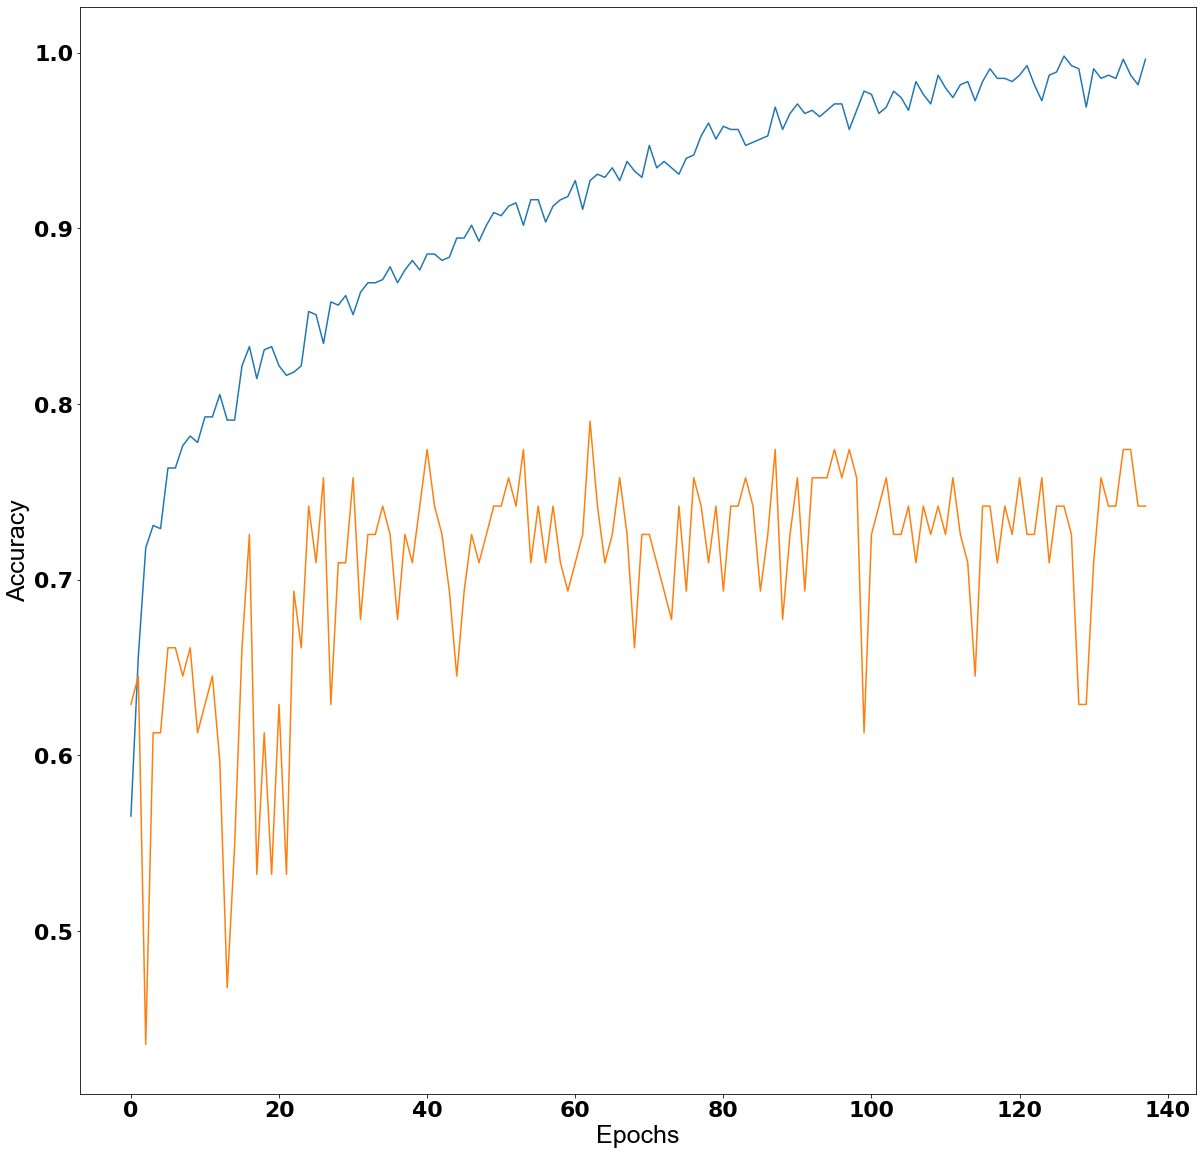

In [19]:
#plot the accuracy of the training set  and the validation set of the model
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)
axis_font = {'fontname':'Arial', 'size':'25'}

plt.figure(figsize=[20,20])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('Accuracy', **axis_font)
plt.xlabel('Epochs', **axis_font)

plt.show()

In [20]:
len(predictions)
len(dates)

150

# Confusion Matrix

In [21]:
%matplotlib inline

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title="Confusion Matrix",
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype("float")/ cm.sum(axis=1)[:,np.newaxis]
        print ("Normalised confusion matrix")
    else:
        print ("Confusion matrix, without normalisation")
        
    print (cm)
    
    thresh = cm.max()/2
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
        horizontalalignment = "center",
        color="white" if cm[i,j] > thresh else "black" )
        
    plt.tight_layout()
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    
    

W0809 12:07:51.974632 4495779264 font_manager.py:1282] findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
W0809 12:07:51.982256 4495779264 font_manager.py:1282] findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
W0809 12:07:52.008265 4495779264 font_manager.py:1282] findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


Confusion matrix, without normalisation
[[25 33]
 [ 3 89]]


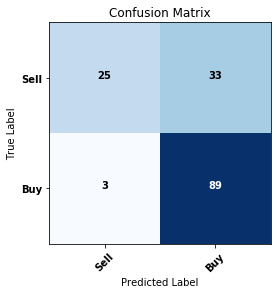

In [22]:
cm = confusion_matrix(y_test, predictions)
cm_labels = ['Sell', 'Buy']
plot_confusion_matrix(cm, cm_labels, title="Confusion Matrix")

In [23]:
#empty dict to store date and the associated prediction for it 
prediction_dict = dict()
#delete the last date as it will be out of bounds
 


In [27]:
#convert dates series into a list
dates = list(dates)


predictions = list(predictions)

for i in range(len(dates)):
    prediction_dict[dates[i]] = predictions[i]

In [45]:
MSFT_dates = (dates[:50])
MSFT_preds = predictions[:50]

AAPL_dates = dates[51:100]
AAPL_preds = predictions[51:100]

AMZN_dates = (dates[100:])
AMZN_preds = predictions[100:]

['2015-05-29',
 '2015-06-30',
 '2015-07-31',
 '2015-08-31',
 '2015-09-30',
 '2015-10-30',
 '2015-11-30',
 '2015-12-31',
 '2016-01-29',
 '2016-02-29',
 '2016-03-31',
 '2016-04-29',
 '2016-05-31',
 '2016-06-30',
 '2016-07-29',
 '2016-08-31',
 '2016-09-30',
 '2016-10-31',
 '2016-11-30',
 '2016-12-30',
 '2017-01-31',
 '2017-02-28',
 '2017-03-31',
 '2017-04-28',
 '2017-05-31',
 '2017-06-30',
 '2017-07-31',
 '2017-08-31',
 '2017-09-29',
 '2017-10-31',
 '2017-11-30',
 '2017-12-29',
 '2018-01-31',
 '2018-02-28',
 '2018-03-29',
 '2018-04-30',
 '2018-05-31',
 '2018-06-29',
 '2018-07-31',
 '2018-08-31',
 '2018-09-28',
 '2018-10-31',
 '2018-11-30',
 '2018-12-31',
 '2019-01-31',
 '2019-02-28',
 '2019-03-29',
 '2019-04-30',
 '2019-05-31',
 '2019-06-28']

In [52]:
def pred_to_df(list_of_dates, list_of_preds):
    """takes a list of dates and a list of predictions for the dates and creates a dataframe object"""
    #dict to be transformed into df
    empty_dict = dict()
    for i in range(len(list_of_dates)):
        empty_dict[list_of_dates[i]] = list_of_preds[i]
        
    preds_df = pd.DataFrame.from_dict(empty_dict)
    preds_df = preds_df.T
    
    return preds_df

    

In [53]:
MSFT_df = pred_to_df(MSFT_dates,MSFT_preds)
AAPL_df = pred_to_df(AAPL_dates, AAPL_preds)
AMZN_df = pred_to_df(AMZN_dates, AMZN_preds)


,0
2015-05-29,0
2015-06-30,1
2015-07-31,1
2015-08-31,0
2015-09-30,1
2015-10-30,1
2015-11-30,1
2015-12-31,1
2016-01-29,0
2016-02-29,1


In [ ]:
export_predictions  = MSFT_df.to_csv('MSFT_15_19_preds_1d_cnn_binary.csv')
export_predictions_two  = AAPL_df.to_csv('AAPL_15_19_preds_1d_cnn_binary.csv')
export_predictions_three = AMZN_df.to_csv('AMZN_15_19_preds_1d_cnn_binary.csv')



In [30]:
export_predictions = predictions_df.to_csv(r'predictions.csv')
